In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, r2_score, accuracy_score, f1_score
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
import catboost

# 1. Загрузка, описание и анализ данных

Загрузка данных

In [2]:
df = pd.read_csv('./data.csv')

Первые 10 примеров датасета

In [3]:
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
5,58,0,0,100,248,0,0,122,0,1.0,1,0,2,1
6,58,1,0,114,318,0,2,140,0,4.4,0,3,1,0
7,55,1,0,160,289,0,0,145,1,0.8,1,1,3,0
8,46,1,0,120,249,0,0,144,0,0.8,2,0,3,0
9,54,1,0,122,286,0,0,116,1,3.2,1,2,2,0


Наличие/отсутсвие пропусков

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


Гистограммы признаков

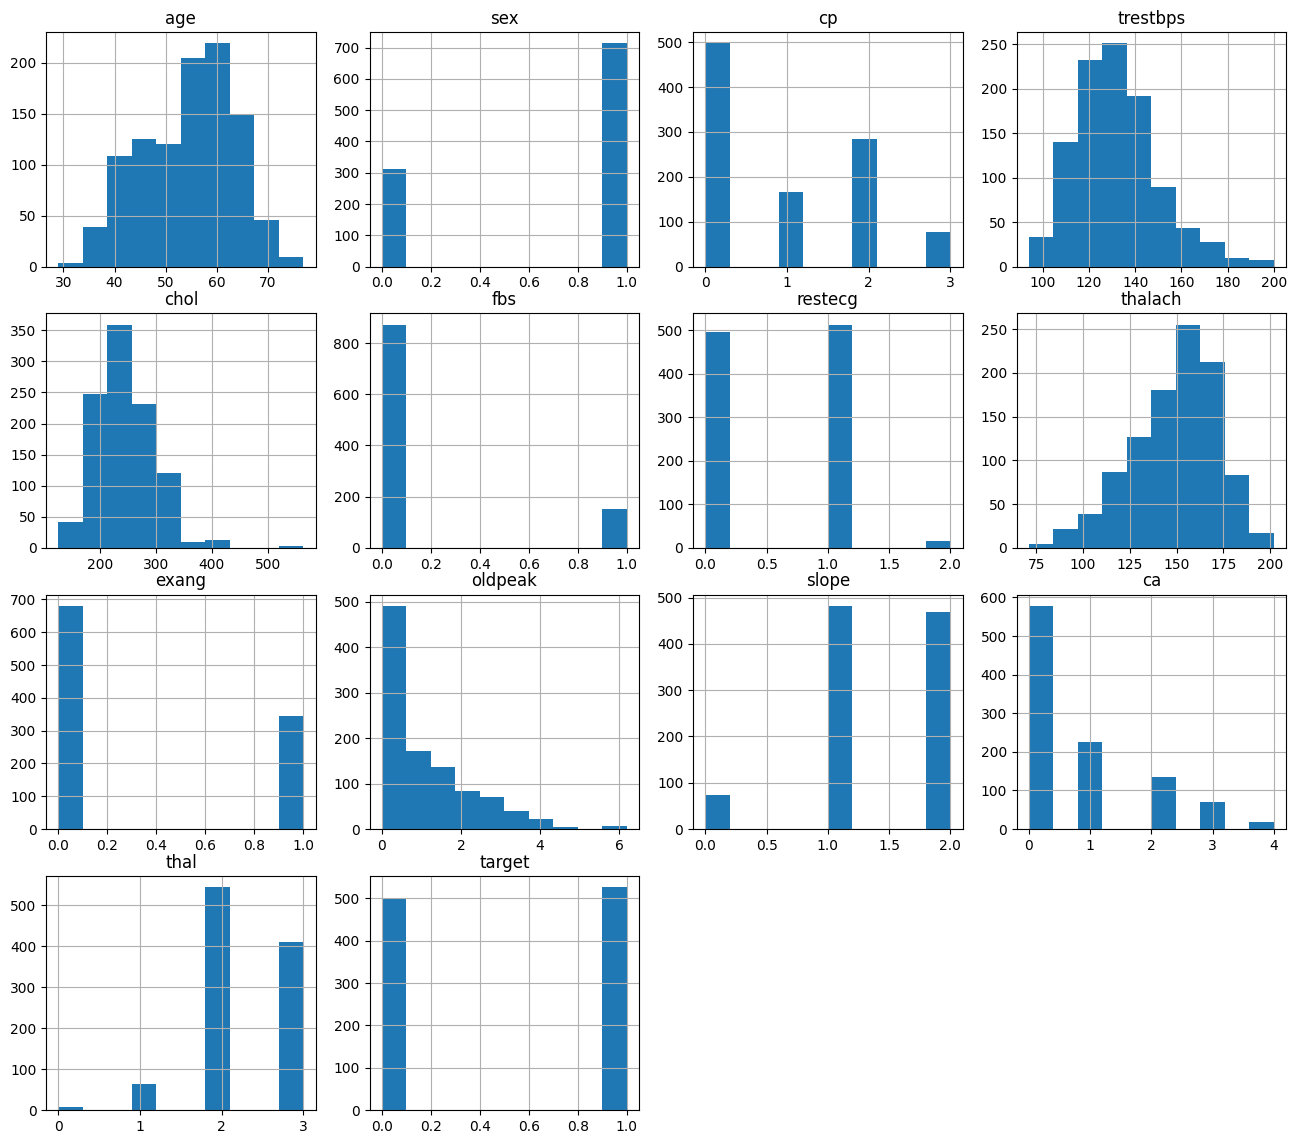

In [5]:
plt.figure(figsize=(16, 14))
for index in range(len(df.columns)):
    plt.subplot(4, 4, index + 1)
    df.iloc[:, index].hist(bins=10)
    plt.title(df.columns[index])


f1 - количественные признаки
f2 - категориальные

In [6]:
f1 = ['oldpeak', 'thalach', 'chol', 'trestbps', 'age']
f2 = [i for i in df.columns if i not in f1 and i != 'target']

Далее можно увидеть различия в выборках сгрупированных по целевой переменной. Так как распределение f1 признаков не является нормальным, то приенять t критерий для оценки статистической разности между группами нельзя, поэтому применяется критерий манна-уитни

In [7]:
df.groupby(by='target')[f1].mean()

,oldpeak,thalach,chol,trestbps,age
target,,,,,
0,1.600200,139.130261,251.292585,134.106212,56.569138
1,0.569962,158.585551,240.979087,129.245247,52.408745


In [8]:
for i in f1:
    _, p_value = stats.shapiro(df[i])
    if p_value > 0.01:
        print(f'{i} - p-value: {p_value}, данные имеют нормальное распределение')
    else:
        print(f'{i} - p-value: {p_value}, данные не имеют нормального распределения')

oldpeak - p-value: 4.6695360161556085e-30, данные не имеют нормального распределения
thalach - p-value: 1.554584759533295e-11, данные не имеют нормального распределения
chol - p-value: 4.0010225784919354e-18, данные не имеют нормального распределения
trestbps - p-value: 2.1954922468659646e-15, данные не имеют нормального распределения
age - p-value: 5.04160047043456e-09, данные не имеют нормального распределения


In [9]:
for col in f1:
    _, p_value = stats.mannwhitneyu(df[df['target'] == 0][col], df[df['target'] == 1][col], alternative='two-sided')
    if p_value > 0.01:
        print(f'{col} - p-value: {p_value}, нет статистически значимых различий между группами')
    else:
        print(f'{col} - p-value: {p_value}, есть статистически значимые различия между группами')

oldpeak - p-value: 1.4469728736988233e-44, есть статистически значимые различия между группами
thalach - p-value: 4.785574678935264e-43, есть статистически значимые различия между группами
chol - p-value: 2.104397673633351e-05, есть статистически значимые различия между группами
trestbps - p-value: 0.00023305716378225312, есть статистически значимые различия между группами
age - p-value: 1.4676312173703238e-14, есть статистически значимые различия между группами


<Axes: >

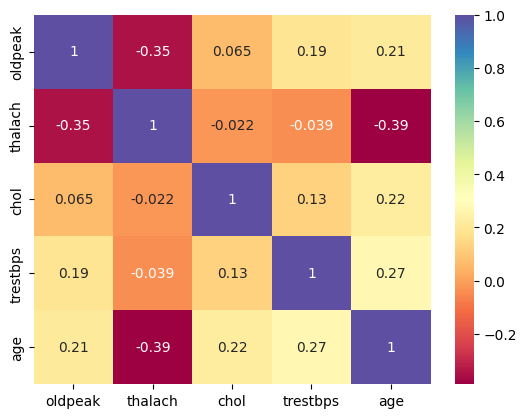

In [10]:
sns.heatmap(df[f1].corr(), cmap='Spectral', annot=True)

Как можно будет увидеть далее fbs вносит наименьший вклад в формирование целевой переменной

In [11]:
for col in f2:
    contingency_table = pd.crosstab(df[col], df.target)
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    if p > 0.1:
        print(f'{col} - не зависит от целевой переменой')
    else:
        print(f'{col} - зависит от целевой переменой')

sex - зависит от целевой переменой
cp - зависит от целевой переменой
fbs - не зависит от целевой переменой
restecg - зависит от целевой переменой
exang - зависит от целевой переменой
slope - зависит от целевой переменой
ca - зависит от целевой переменой
thal - зависит от целевой переменой


<Axes: >

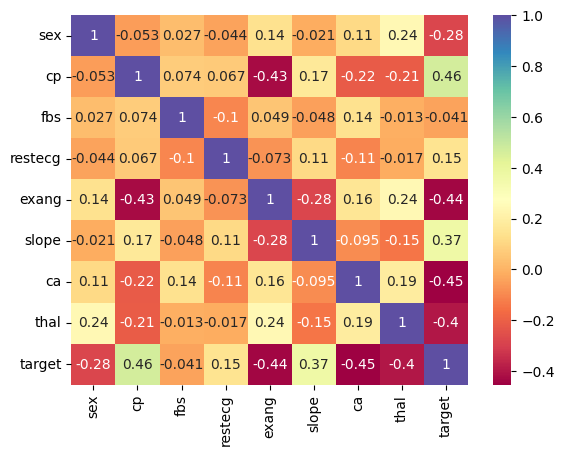

In [12]:
sns.heatmap(df[[*f2, 'target']].corr('spearman'), cmap='Spectral', annot=True)

В датасете присутствует небольшое чисо выбросов. Далее обучение моделей будет проводиться на исходном и очищенном от выбросов датасетах, для сравнения эффективности моделей.

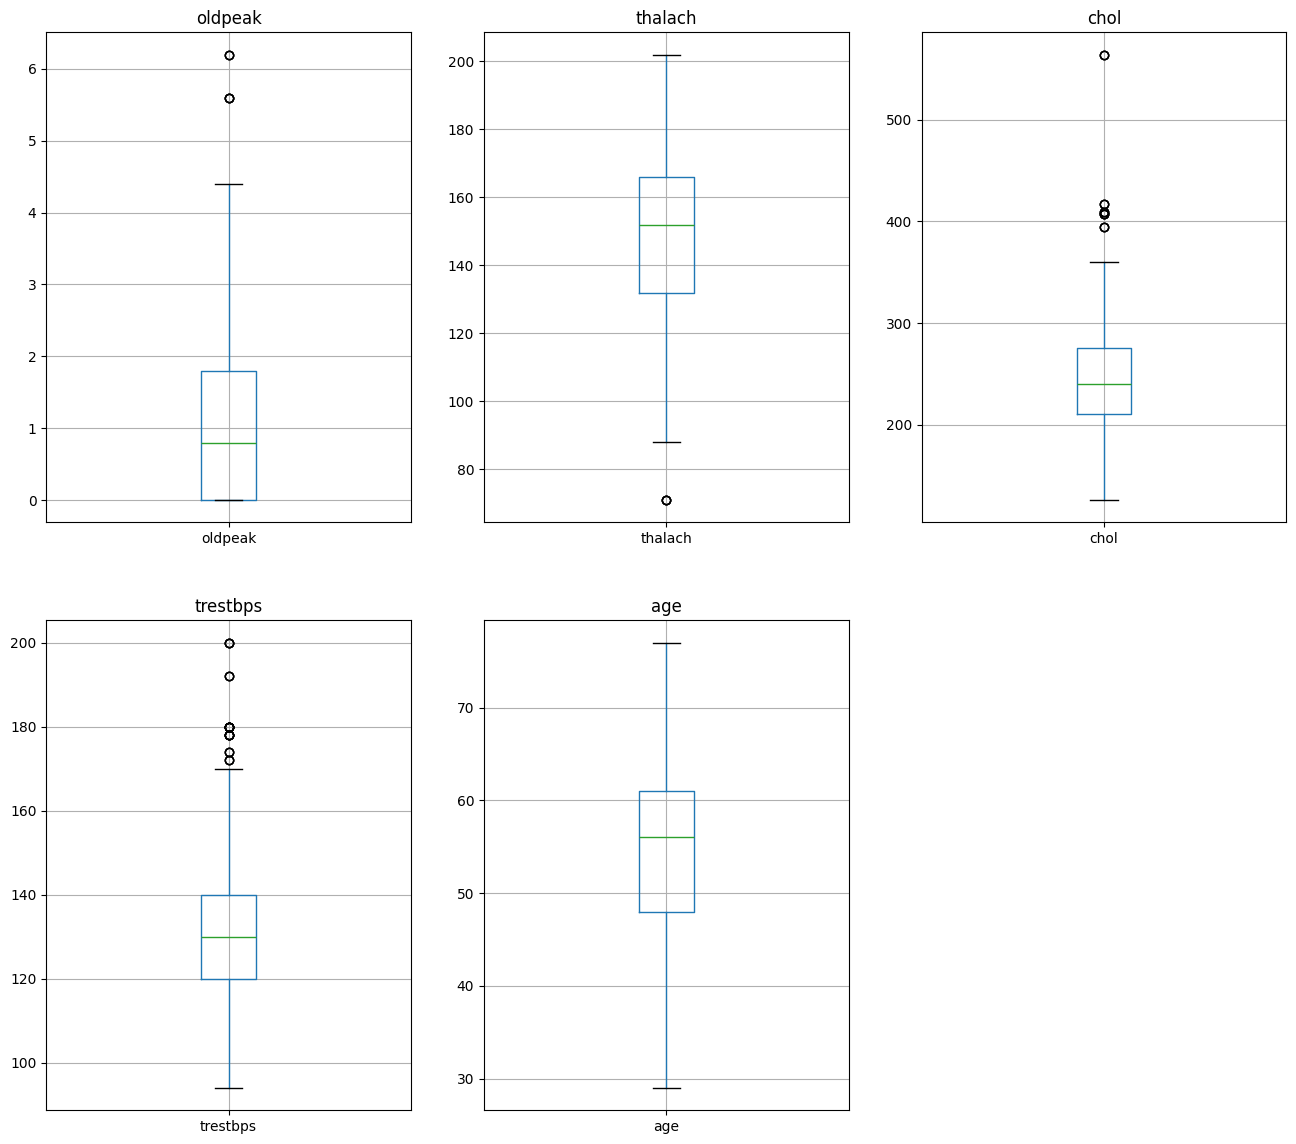

In [13]:
plt.figure(figsize=(16, 14))
for index in range(len(f1)):
    plt.subplot(2, 3, index + 1)
    df.boxplot(column=f1[index])
    plt.title(f1[index])

# 2. Построение модели и иллюстрация важности признаков

Разбиение датасета на обучающую и тренировочную выборки

In [14]:
x_train, x_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df[df.columns[-1]], train_size=0.8, random_state=12312)

Создание копии датасета и удаление выбросов

In [15]:
x_train_without_outlier = x_train.copy()
x_train_without_outlier['target'] = y_train.copy()

for col in f1:
    Q1 = x_train_without_outlier[col].quantile(0.25)
    Q3 = x_train_without_outlier[col].quantile(0.75)
    IQR = Q3 - Q1
    x_train_without_outlier = x_train_without_outlier[(x_train_without_outlier[col] >= Q1 - 1.5 * IQR) & (x_train_without_outlier[col] <= Q3 + 1.5 * IQR)]

x_train_without_outlier, y_train_without_outlier = x_train_without_outlier.iloc[:, :-1], x_train_without_outlier.iloc[:, -1]
x_test_without_outlier = x_test.copy()

Нормирование данных. Т.к. модели не должны видеть обучающие данные, StandardScaler аналогично работал с тренировочными.

In [16]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train.loc[:, :] = scaler.transform(x_train)
x_test.loc[:, :] = scaler.transform(x_test)

scaler_without_outlier = StandardScaler()
scaler_without_outlier.fit(x_train_without_outlier)
x_train_without_outlier.loc[:, :] = scaler_without_outlier.transform(x_train_without_outlier)
x_test_without_outlier.loc[:, :] = scaler_without_outlier.transform(x_test_without_outlier)

Для обуения взял 4 модели: логистическую регрессию, метод опорных векторов, случайный лес и градиентный бустинг.

In [17]:
models = {'Linear Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVC': SVC(),
    'CatBoost': catboost.CatBoostClassifier(
    random_seed=12312,
    iterations=200,
    learning_rate=0.1,
    eval_metric='Accuracy',
    custom_metric=['Accuracy'],
    use_best_model=True)
    }

In [18]:
metrics_df = pd.DataFrame(data={'acc':[], 'f1':[], 'roc_auc':[]})

Как и говорилось ранее модели обучаются на исходных данных и очищенных от выбросов.

In [19]:
for id, model in models.items():
    if id == "CatBoost":
        model.fit(x_train, y_train,
                  eval_set=(x_test, y_test),
                  plot=False,
                  verbose=False)
    else:
        model.fit(x_train, y_train)

    predict_model = model.predict(x_test)
    
    metrics_df.loc[id, 'acc'] = accuracy_score(y_test, predict_model)
    metrics_df.loc[id, 'f1'] = f1_score(y_test, predict_model)
    metrics_df.loc[id, 'roc_auc'] = roc_auc_score(y_test, predict_model)

for id, model in models.items():
    if id == "CatBoost":
        model.fit(x_train_without_outlier, y_train_without_outlier,
                  eval_set=(x_test_without_outlier, y_test),
                  plot=False,
                  verbose=False)
    else:
        model.fit(x_train_without_outlier, y_train_without_outlier)

    predict_model = model.predict(x_test_without_outlier)
    
    metrics_df.loc[id, 'acc_without'] = accuracy_score(y_test, predict_model)
    metrics_df.loc[id, 'f1_without'] = f1_score(y_test, predict_model)
    metrics_df.loc[id, 'roc_auc_without'] = roc_auc_score(y_test, predict_model)

Наилучшие резульаты у бустинга и случайного леса на исходном наборе данных.

In [20]:
metrics_df

,acc,f1,roc_auc,acc_without,f1_without,roc_auc_without
Linear Regression,0.848780,0.864629,0.845662,0.853659,0.869565,0.850087
Random Forest,0.985366,0.986547,0.986726,0.980488,0.981982,0.982301
SVC,0.921951,0.929825,0.920114,0.912195,0.920354,0.911264
CatBoost,0.985366,0.986547,0.986726,0.980488,0.981982,0.982301


Кросс валидация и сравнения моделей на устойчивость к изменению входных данных.

In [36]:
cv_rf = cross_val_score(models['Random Forest'], x_train, y_train)

params = {
    'loss_function': 'Logloss',
    'iterations': 150,
    'custom_loss': 'Accuracy',
    'random_seed': 63,
    'learning_rate': 0.1
}

cv_catboost = catboost.cv(
    params=params,
    pool=catboost.Pool(x_train, label=y_train),
    fold_count=5,
    shuffle=False,
    partition_random_seed=12312,
    plot=False,
    stratified=False, 
    verbose=False)

cv_catboost_mean = cv_catboost['test-Accuracy-mean'].tolist()[-1]
cv_catboost_std = cv_catboost['test-Accuracy-std'].tolist()[-1]

Training on fold [0/5]

bestTest = 0.0420832612
bestIteration = 149

Training on fold [1/5]

bestTest = 0.0779959649
bestIteration = 136

Training on fold [2/5]

bestTest = 0.05973304364
bestIteration = 149

Training on fold [3/5]

bestTest = 0.05432708661
bestIteration = 148

Training on fold [4/5]

bestTest = 0.0649909548
bestIteration = 140



In [37]:
print(f'cv_rf mean: {cv_rf.mean()}, cv_rf std: {cv_rf.std()}', f'cv_catboost mean: {cv_catboost_mean}, cv_catboost std: {cv_catboost_std}', sep='\n')

cv_rf mean: 0.9865853658536585, cv_rf std: 0.007110916944933299
cv_catboost mean: 0.9829268292682926, cv_catboost std: 0.01090764867073069


Оценка важности признаков получена усредненим ответа бустинга и случайного леса.

In [38]:
feature = pd.DataFrame({'CatBoost':models['CatBoost'].get_feature_importance(), 'Random Forest':models['Random Forest'].feature_importances_}, index=df.columns[:-1])
feature['Random Forest'] *= 100
feature['diff'] = feature['CatBoost'] - feature['Random Forest']
feature['mean'] = feature['CatBoost'] + feature['Random Forest']
feature['mean'] /= 2
feature.sort_values(by='mean', ascending=False, inplace=True)
feature

,CatBoost,Random Forest,diff,mean
cp,13.548877,13.074052,0.474825,13.311464
ca,14.152586,12.100877,2.051709,13.126731
thal,10.344452,12.373519,-2.029067,11.358985
thalach,8.645073,11.129804,-2.484732,9.887439
oldpeak,8.899615,10.769686,-1.870071,9.834651
age,8.538512,9.409441,-0.870929,8.973977
chol,7.076943,7.407605,-0.330662,7.242274
trestbps,6.146754,7.024965,-0.878211,6.585860
sex,6.664419,4.139217,2.525202,5.401818
exang,4.342682,5.322381,-0.979698,4.832531


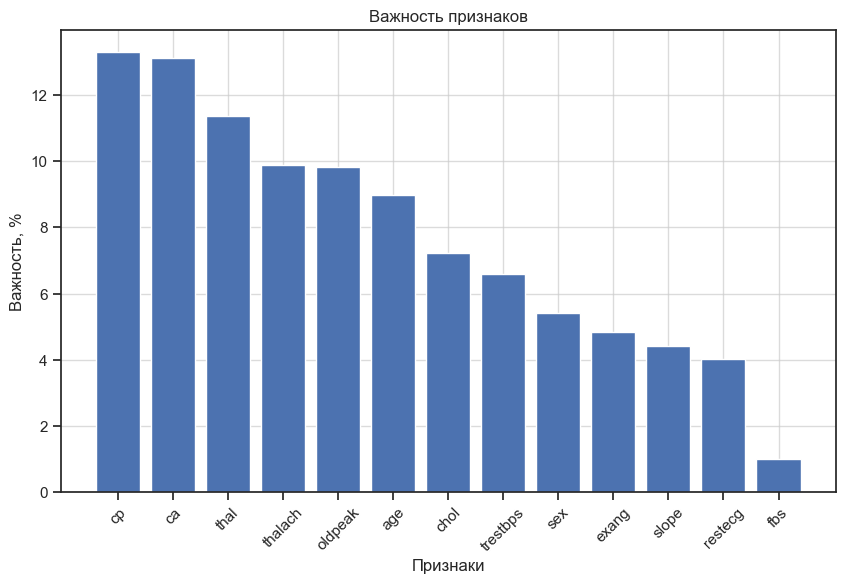

In [46]:
sns.set(style='ticks')
plt.figure(figsize=(10, 6))
plt.title('Важность признаков')
plt.bar(feature.index, feature['mean'])
plt.ylabel('Важность, %')
plt.xlabel('Признаки')
plt.xticks(rotation=45)
plt.grid(alpha=0.7)
plt.show()